In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/company-bankruptcy-prediction/data.csv


In [2]:
from scipy.stats import f_oneway
from matplotlib import pyplot as plt
import seaborn as sns
import math
from imblearn import over_sampling
from imblearn import under_sampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv(r'/kaggle/input/company-bankruptcy-prediction/data.csv')

In [4]:
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
data.shape

(6819, 96)

In [6]:
df = data.copy()

In [7]:
pd.set_option('display.max_columns', None)

# 1. Exploratory Data Analysis

## 1.1. Xem xét biến mục tiêu

[Text(0, 0, '6599'), Text(0, 0, '220')]

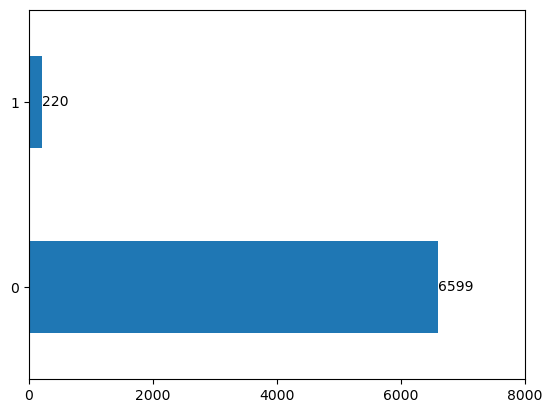

In [8]:
ax = df['Bankrupt?'].value_counts().plot(kind = 'barh')
ax.set_xticks([0, 2000, 4000, 6000, 8000])
ax.bar_label(ax.containers[0], padding = 0)

Dữ liệu phân loại này bị lệch rất nặng, hầu hết các công ty trong đây đều bị phá sản

## 1.2. Xem xét biến độc lập

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Không có dữ liệu bị thiếu, tất cả các biến là float, trừ biến mục tiêu và hai biến flag. Xem xét hai biến flag này.

In [10]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

In [11]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

Vì hai biến này có độ purity cao, nên sẽ không quan tâm hai biến flag này trong mối liên hệ với biến mục tiêu

### Mối liên hệ của biến độc lập với biến phụ thuộc

Để loại bỏ những biến độc lập không liên quan tới biến phụ thuộc

In [12]:
num_cols = list(df.columns)
num_cols.remove('Bankrupt?')
num_cols.remove(' Liability-Assets Flag')
num_cols.remove(' Net Income Flag')
cat_cols = [' Liability-Assets Flag', ' Net Income Flag']

In [13]:
to_remove = []
for col in num_cols:
    categories = df.groupby('Bankrupt?')[col].apply(list)
    p_val = f_oneway(*categories)[1]
    if (p_val > 0.05):
        to_remove.append((col, p_val))

#drop những biến không có sự khác nhau
for col in list(zip(*to_remove))[0]:
    num_cols.remove(col)

In [14]:
len(num_cols)

58

In [15]:
X = df[num_cols]
y = df['Bankrupt?']

### Xem phân phối của các biến còn lại

Có thể có những biến không có phân phối chuẩn, cần thực hiện transformation để về dạng phân phối chuẩn

array([[<AxesSubplot:title={'center':' ROA(C) before interest and depreciation before interest'}>,
        <AxesSubplot:title={'center':' ROA(A) before interest and % after tax'}>,
        <AxesSubplot:title={'center':' ROA(B) before interest and depreciation after tax'}>,
        <AxesSubplot:title={'center':' Operating Gross Margin'}>,
        <AxesSubplot:title={'center':' Realized Sales Gross Margin'}>,
        <AxesSubplot:title={'center':' Research and development expense rate'}>],
       [<AxesSubplot:title={'center':' Cash flow rate'}>,
        <AxesSubplot:title={'center':' Tax rate (A)'}>,
        <AxesSubplot:title={'center':' Net Value Per Share (B)'}>,
        <AxesSubplot:title={'center':' Net Value Per Share (A)'}>,
        <AxesSubplot:title={'center':' Net Value Per Share (C)'}>,
        <AxesSubplot:title={'center':' Persistent EPS in the Last Four Seasons'}>],
       [<AxesSubplot:title={'center':' Cash Flow Per Share'}>,
        <AxesSubplot:title={'center':' Operat

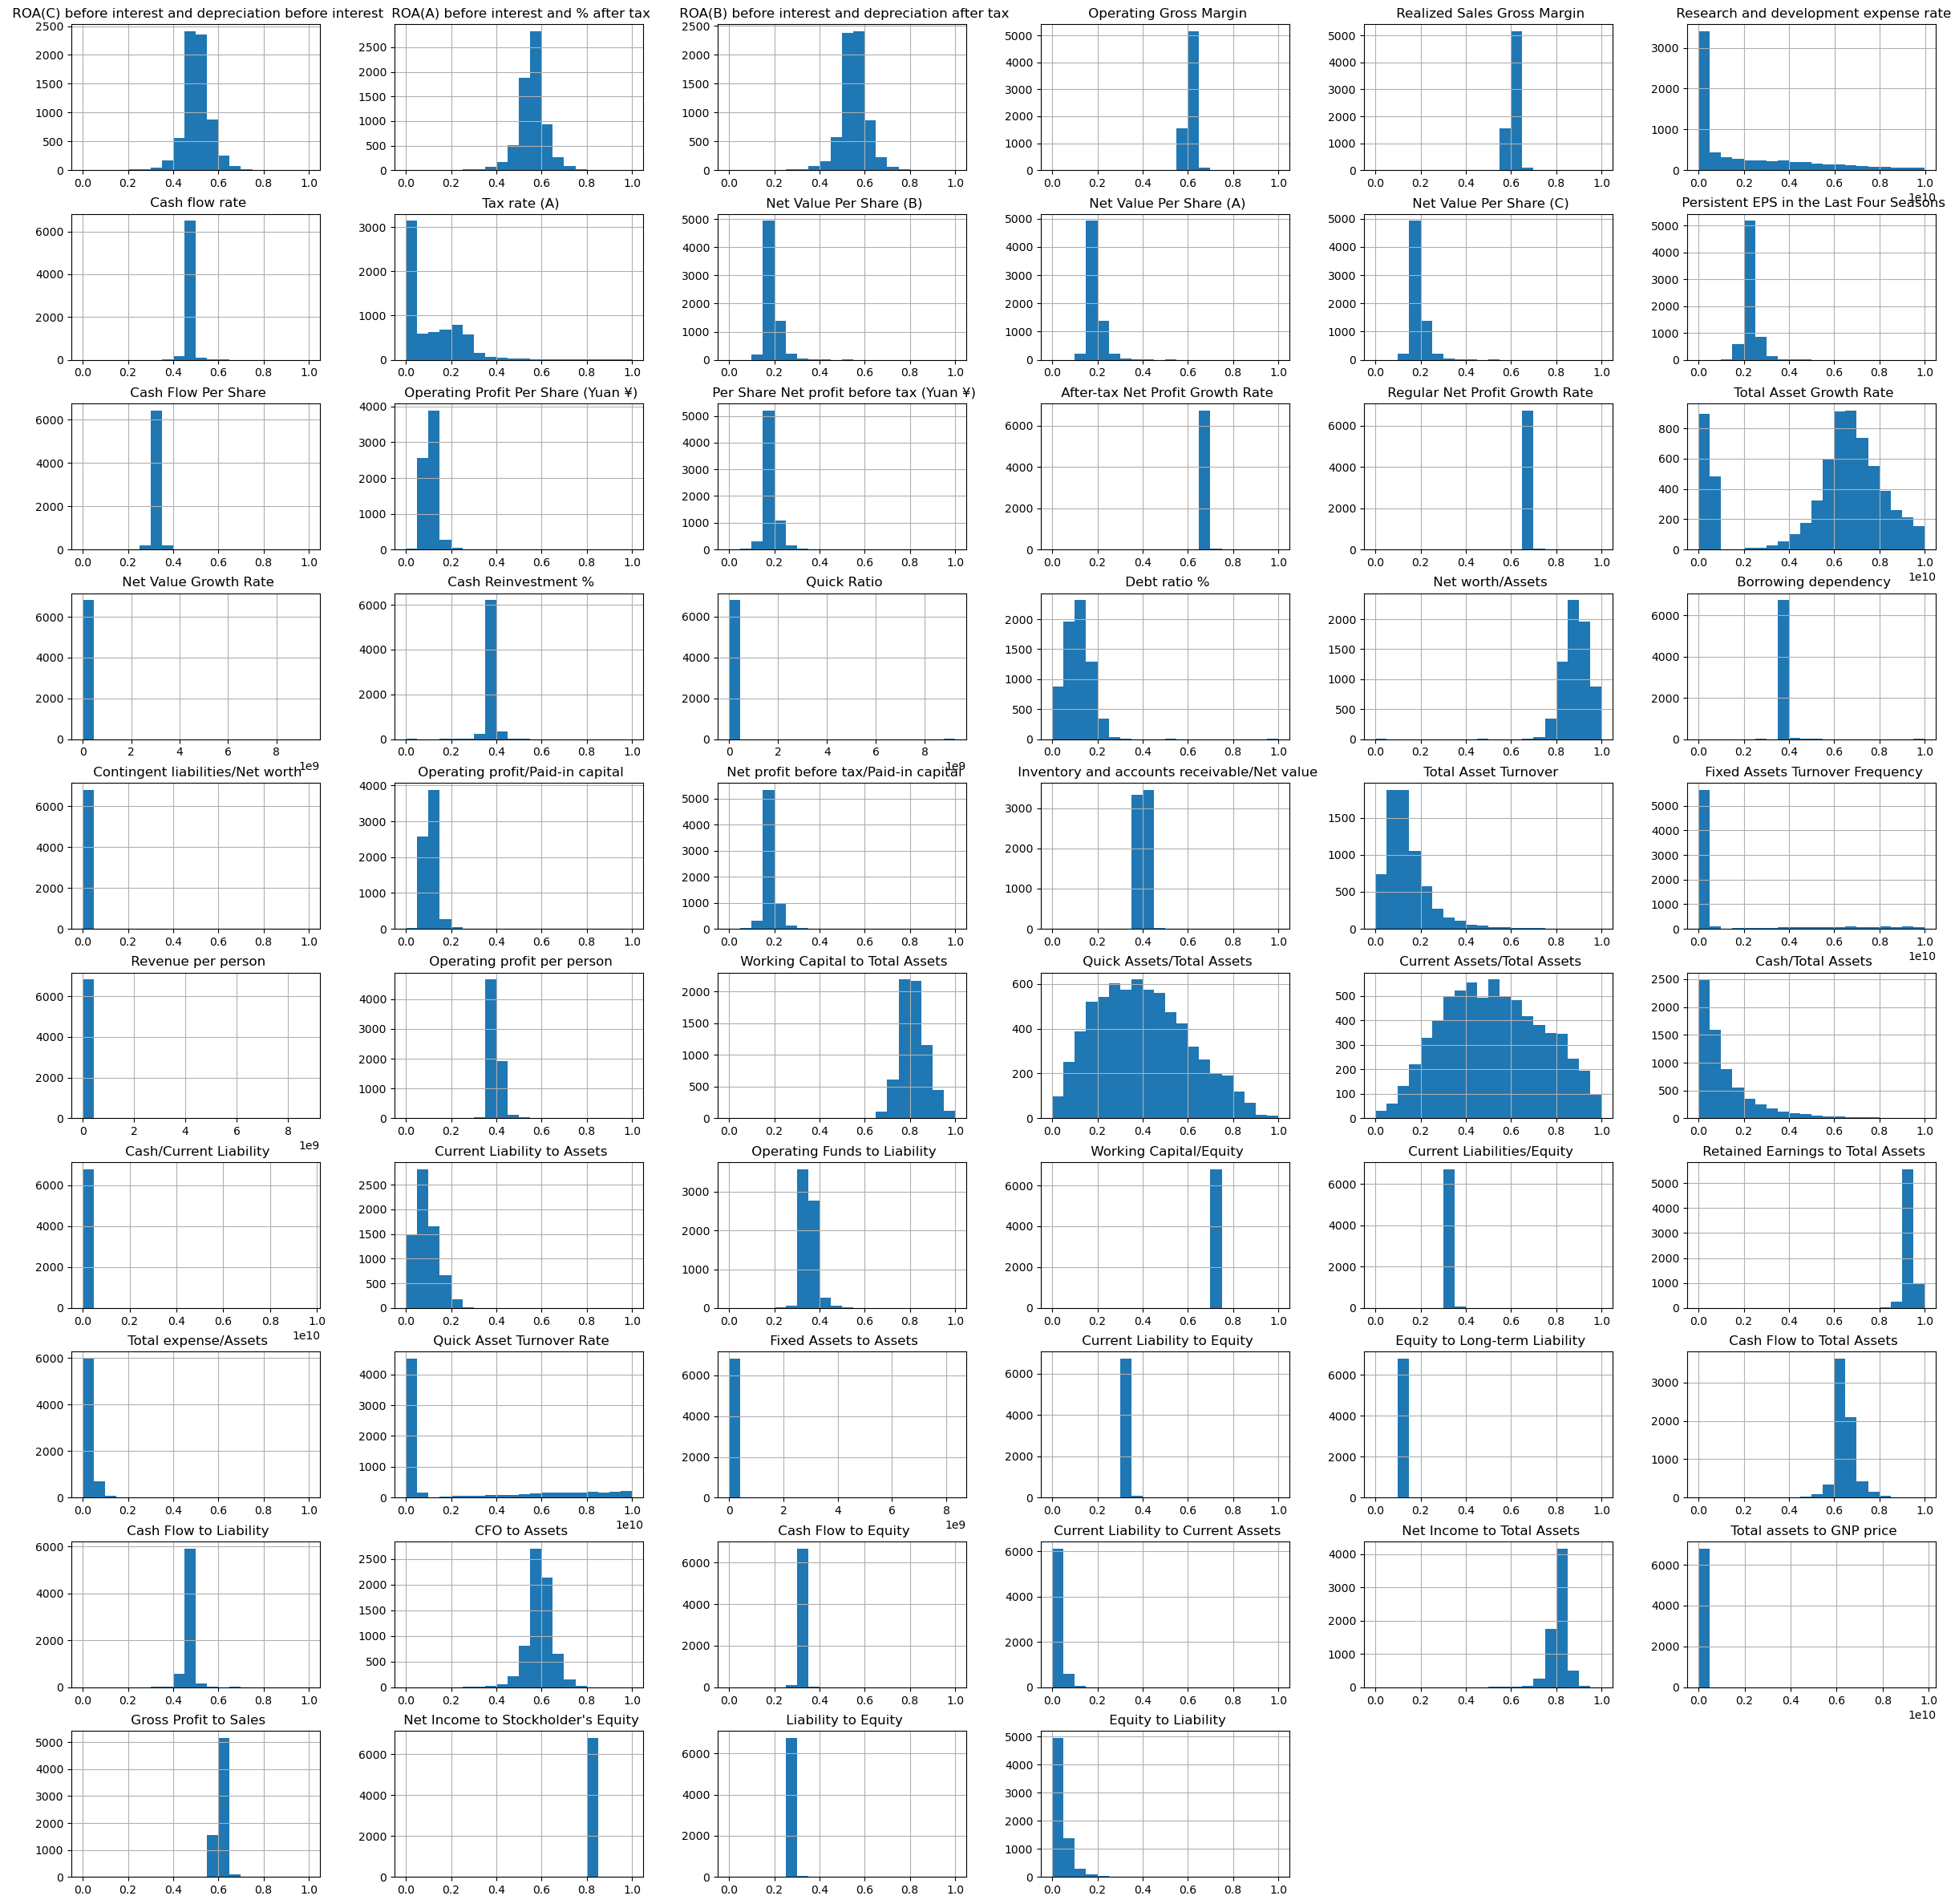

In [16]:
X.hist(figsize = (30, 30), layout = (10, 6), bins = 20)

Có thể thấy nhiều biến có hiện tượng lệch không có dạng hình chuông, không cùng scale (Như Total assets to GNP price, Research and development expense rate có thể có giá trị tới 1e10), do vậy sẽ thực hiện MinMaxScaler những biến này lại.

Bên cạnh đó, cx cần thực hiện log transformation đối với một số biến bị skew (không theo dạng hình chuông)

In [17]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [18]:
from scipy.stats import skew
for col in X.columns:
    if np.abs(skew(X[col])) > 1:
        X[col] = np.log1p(X[col])

### Visualize data với PCA

<AxesSubplot:>

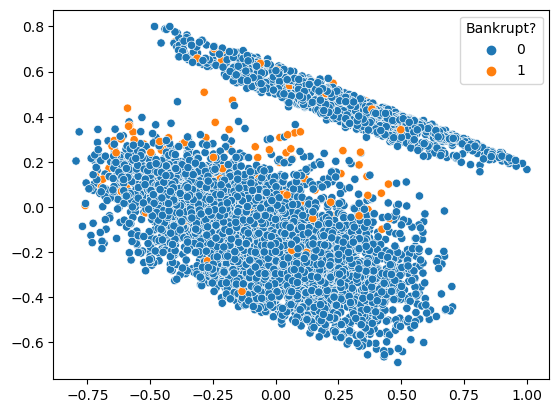

In [19]:
pca = PCA(n_components = 2)

data = pca.fit(X).transform(X)

data = list(zip(*data))

sns.scatterplot(x = data[0], y = data[1], hue = y)



Dữ liệu class 0 và 1 khá lẫn lộn v

# 2. Model Training

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15)

print("Class distribution of y:", np.unique(y, return_counts = True))
print("Class distribution of y_train:", np.unique(y_train, return_counts = True))
print("Class distribution of y_test:", np.unique(y_test, return_counts = True))

Class distribution of y: (array([0, 1]), array([6599,  220]))
Class distribution of y_train: (array([0, 1]), array([5609,  187]))
Class distribution of y_test: (array([0, 1]), array([990,  33]))


## 2.1. Resampling the dataset

Do dữ liệu class 0 và 1 khá lẫn lộn với nhau, thử cả ros, rus, và smote

In [21]:
ros = over_sampling.RandomOverSampler(random_state = 0, shrinkage = 0.1)
rus = under_sampling.RandomUnderSampler(random_state = 20)
smote = over_sampling.SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

print('Class distribution of y train resampled:',np.unique(y_resampled, return_counts = True))

Class distribution of y train resampled: (array([0, 1]), array([5609, 5609]))


## 2.2. Train models

Xem trước từng model để lựa chọn một số model perform tốt nhất, scoring là f1-score

In [22]:
models = [LogisticRegression(max_iter = 500), SVC(), RandomForestClassifier(), AdaBoostClassifier(), KNeighborsClassifier()]

for model in models:
    print(model)
    scores = cross_val_score(model, X_resampled, y_resampled, scoring = 'f1')
    print('Average score of using this model for prediction', scores.mean())
    

LogisticRegression(max_iter=500)
Average score of using this model for prediction 0.8908198353464953
SVC()
Average score of using this model for prediction 0.9082397234996045
RandomForestClassifier()
Average score of using this model for prediction 0.976795243731528
AdaBoostClassifier()
Average score of using this model for prediction 0.9175385168567092
KNeighborsClassifier()
Average score of using this model for prediction 0.9543843740499642


In [23]:
model = RandomForestClassifier()
params = {'n_estimators':[250, 400, 500], 
         'criterion':['entropy', 'gini']}
gscv = GridSearchCV(model, params, scoring = 'f1')
gscv.fit(X_resampled, y_resampled)
y_hat = gscv.predict(X_test)
print(classification_report(y_hat, y_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       973
           1       0.45      0.30      0.36        50

    accuracy                           0.95      1023
   macro avg       0.71      0.64      0.67      1023
weighted avg       0.94      0.95      0.94      1023



In [24]:
gscv.best_params_

{'criterion': 'gini', 'n_estimators': 250}

In [25]:
model2 = AdaBoostClassifier()
params2 = {'n_estimators':[50, 100], 
         'learning_rate':[0.01, 0.05, 0.1, 0.5, 1]}
gscv2 = GridSearchCV(model2, params2, scoring = 'f1')
gscv2.fit(X_resampled, y_resampled)
y_hat = gscv2.predict(X_test)
print(classification_report(y_hat, y_test))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       918
           1       0.55      0.17      0.26       105

    accuracy                           0.90      1023
   macro avg       0.73      0.58      0.60      1023
weighted avg       0.87      0.90      0.88      1023



In [26]:
gscv2.best_params_

{'learning_rate': 1, 'n_estimators': 100}

Kết luận: Các bước thực hiện đối với dữ liệu này
- MinMaxScale và Log1P Transformation để biến đổi dữ liệu
- SMOTE để thực hiện Over Sampling
- RandomForestClassifier để thực hiện phân loại

So với các phương pháp khác là SMOTE vs ROS, RUS và RandomForestClassifier vs các model khác thì kết quả nhận được đang là tốt nhất